In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import time as time
import matplotlib.pyplot as plt
import os.path
import random as random
import matplotlib.image as mpimg
%matplotlib inline
print("TensorFlow version:",tf.__version__)

TensorFlow version: 1.3.0


In [2]:
train_folder="C:/Users/Siby/Documents/TensorFlow_scripts/TensorFlow_tutorial/simpsons_dataset/train"
valid_folder="C:/Users/Siby/Documents/TensorFlow_scripts/TensorFlow_tutorial/simpsons_dataset/valid"

In [3]:
def load_existing_model(model_name='simpsons_model.h5'):
    if os.path.isfile(model_name) == True:
        print("Model Exists...loading")
        trained_model = tf.contrib.keras.models.load_model(model_name)
        print("Model Loaded")
        trained_model.summary()
        #print(load_model.get_config())
        return trained_model
    else:
        print("Model does not exist")
        return None

In [4]:
def count_samples(main_folder):
    i=0
    total_samples=0
    for folder in os.listdir(main_folder):
        for file in os.listdir(os.path.join(main_folder,folder)):
            i=i+1
        print("Number of pictures of ",folder,'is',i)
        total_samples = total_samples+i
        i=0
    print("Total number of pictures is",total_samples)
    return total_samples

In [5]:
def resize_img(image):
    Image_width = 150
    Image_height = 150
    import tensorflow as tf
    return tf.image.resize_images(image, (Image_width, Image_height),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)    

In [6]:
def random_inference(trained_model,image_folder=valid_folder):
    random_folder = random.choice(os.listdir(image_folder)) #Randomly select a folder from directory
    random_file = random.choice(os.listdir(os.path.join(image_folder,random_folder))) 
    random_image=mpimg.imread(os.path.join(image_folder,random_folder,random_file))
    print("Inference on image file '{}' in folder '{}' with shape {}".format(random_file,random_folder,random_image.shape))
    
    #plt.figure(figsize=(2,2))
    #plt.imshow(random_image)
    
    #random_image = np.resize(random_image,(1,random_image.shape[0],random_image.shape[1],3))
    random_image = np.expand_dims(random_image, axis=0)
    print(trained_model.predict(random_image)[0])
    print(trained_model.predict_classes(random_image))
    image_with_probalities(image=random_image.squeeze(),class_probs=trained_model.predict(random_image)[0])

In [7]:
def image_with_probalities(image,class_probs=[0.2,0.2,0.2,0.2,0.2]):
    class_names = ('Bart', 'Homer', 'Lisa', 'Maggie', 'Marge')
    y_pos = np.arange(len(class_names))
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
    #f.rcParams['xtick.labelsize'] = 15 
    
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Inferenced Image', fontsize=40)
    ax2.bar(y_pos, class_probs, align='center', alpha=0.5)
    ax2.set_xticks(y_pos)
    ax2.set_xticklabels(class_names,fontdict ={'fontsize': 20,'weight':'bold' }) #y_pos,
    ax2.set_ylabel('Probability',fontdict ={'fontsize': 30})
    ax2.tick_params('y', labelsize =20)
    ax2.set_title('CNN Output', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
total_train_samples =count_samples(main_folder=train_folder)
total_valid_samples =count_samples(main_folder=valid_folder)

Number of pictures of  bart_simpson is 1250
Number of pictures of  homer_simpson is 1250
Number of pictures of  lisa_simpson is 1250
Number of pictures of  maggie_simpson is 121
Number of pictures of  marge_simpson is 1250
Total number of pictures is 5121
Number of pictures of  bart_simpson is 92
Number of pictures of  homer_simpson is 996
Number of pictures of  lisa_simpson is 104
Number of pictures of  maggie_simpson is 7
Number of pictures of  marge_simpson is 41
Total number of pictures is 1240


In [9]:
#Image shape in pixels
Image_width = 150
Image_height = 150

In [10]:
#Generators for feeding data during the train processe
train_datagen = tf.contrib.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=True) #rescale=1./255
test_datagen = tf.contrib.keras.preprocessing.image.ImageDataGenerator()  #rescale=1./255
train_generator = train_datagen.flow_from_directory(train_folder, target_size=(Image_width, Image_height), batch_size=8,class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(valid_folder,target_size=(Image_width, Image_height),batch_size=1200,class_mode='categorical')
print("There are {} unique training samples and {} validation samples".format(train_generator.samples,validation_generator.samples))
#Load validation samples
X_valid,y_valid=next(validation_generator)
print("Shape of input image data",X_valid.shape)

Found 5121 images belonging to 5 classes.
Found 1240 images belonging to 5 classes.
There are 5121 unique training samples and 1240 validation samples
Shape of input image data (1200, 150, 150, 3)


In [11]:
#Convolutional neural network Model is defined here
bias0 =  'zeros'
drop_rate = 0.5
Yclasses =5   #Number of classes
tf.contrib.keras.backend.clear_session()
model = tf.contrib.keras.models.Sequential() 
model.add(tf.contrib.keras.layers.InputLayer(input_shape=(None,None,3),name='InputLayer'))  #Input
model.add(tf.contrib.keras.layers.Lambda(resize_img,name='ResizeImage'))          #Resizing image
model.add(tf.contrib.keras.layers.Lambda(lambda x:x/255.0 -0.5,name='Normalizing'))  #Normalizing values
model.add(tf.contrib.keras.layers.Conv2D(filters=12,kernel_size=(3,3),strides=(2,2),activation='relu',bias_initializer=bias0,padding='same',name='ConvLayer1'))
model.add(tf.contrib.keras.layers.MaxPool2D((2, 2),strides=(2,2),name='MaxPool1'))
model.add(tf.contrib.keras.layers.Conv2D(filters=18,kernel_size=(3,3),strides=(2,2),activation='relu',bias_initializer=bias0,padding='same',name='ConvLayer2'))
model.add(tf.contrib.keras.layers.MaxPool2D((2, 2),strides=(2,2),name='MaxPool2'))
model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut1'))
model.add(tf.contrib.keras.layers.Conv2D(filters=24,kernel_size=(3,3),strides=(2,2),activation='relu',bias_initializer=bias0,padding='same',name='ConvLayer3'))
model.add(tf.contrib.keras.layers.MaxPool2D((2, 2),strides=(2,2),name='MaxPool3'))

model.add(tf.contrib.keras.layers.Flatten(name='Flatten'))
model.add(tf.contrib.keras.layers.Dense(units=10,bias_initializer=bias0,activation='relu',name='FeedForward1'))
model.add(tf.contrib.keras.layers.Dropout(drop_rate,name='DropOut2'))
model.add(tf.contrib.keras.layers.Dense(units=Yclasses,activation='softmax',bias_initializer=bias0,name='OutputLayer'))  
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, None, None, 3)     0         
_________________________________________________________________
ResizeImage (Lambda)         (None, 150, 150, 3)       0         
_________________________________________________________________
Normalizing (Lambda)         (None, 150, 150, 3)       0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 75, 75, 12)        336       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 37, 37, 12)        0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 19, 19, 18)        1962      
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 9, 9, 18)          0         
__________

In [12]:
#Accuracy before training
print(model.metrics_names[0],":",model.test_on_batch(X_valid,y_valid)[0])
print(model.metrics_names[1],":",model.test_on_batch(X_valid,y_valid)[1])

loss : 1.5889
categorical_accuracy : 0.188333


In [15]:
#Callbacks during train for saving data
tb_callback = tf.contrib.keras.callbacks.TensorBoard(log_dir='./logs',histogram_freq=2,write_images=True)
early_stopping = tf.contrib.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
#Tain model
model.fit_generator( train_generator, steps_per_epoch=2000, epochs=1,validation_data=(X_valid,y_valid),callbacks=[tb_callback])
#,callbacks=[tb_callback],
model.save('simpsons_model.h5')
print("Model Saved")

Epoch 1/1
2000/2000 [==============================] - 260s - loss: 1.3009 - categorical_accuracy: 0.4268 - val_loss: 1.0016 - val_categorical_accuracy: 0.6008
Model Saved


In [17]:
model = load_existing_model(model_name='simpsons_model_81.h5')

Model Exists...loading
Model Loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      (None, None, None, 3)     0         
_________________________________________________________________
ResizeImage (Lambda)         (None, 150, 150, 3)       0         
_________________________________________________________________
Normalizing (Lambda)         (None, 150, 150, 3)       0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 73, 73, 6)         456       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 72, 72, 6)         0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 34, 34, 8)         1208      
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 17, 

Inference on image file 'pic_1251.jpg' in folder 'marge_simpson' with shape (416, 288, 3)
[ 0.07781228  0.04401032  0.09365758  0.01911027  0.76540959]
1/1 [==============================] - 0s
[4]


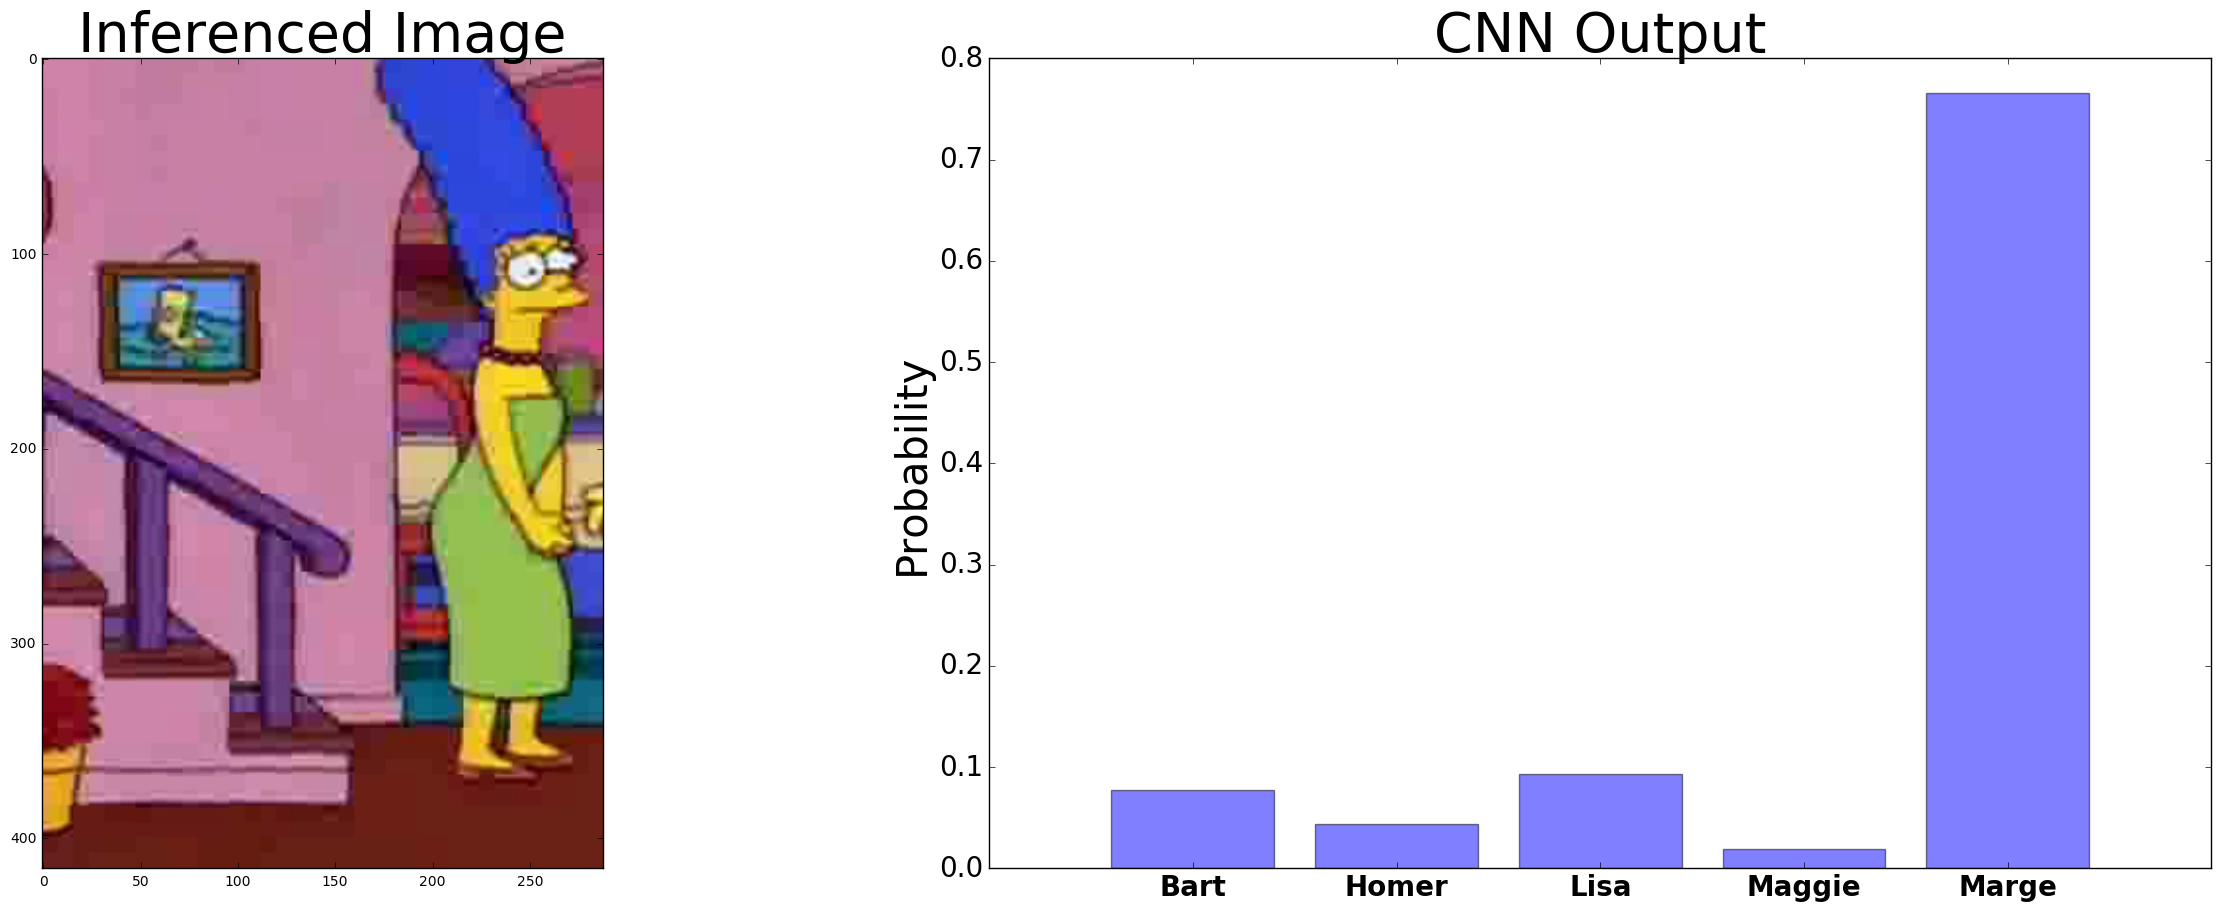

In [16]:
random_inference(trained_model=model,image_folder=valid_folder)

In [17]:
#model.predict_classes(X_valid,batch_size=2)
model.predict_proba(X_valid,batch_size=2)

1200/1200 [==============================] - 3s     


array([[ 0.21346506,  0.53815669,  0.23419699,  0.00470691,  0.00947434],
       [ 0.17502744,  0.62860048,  0.18128079,  0.00563623,  0.00945504],
       [ 0.38519397,  0.18180543,  0.37366125,  0.02576862,  0.03357058],
       ..., 
       [ 0.04777116,  0.89517546,  0.05342688,  0.00097447,  0.00265206],
       [ 0.13839903,  0.65456003,  0.1374135 ,  0.01618829,  0.05343913],
       [ 0.21469916,  0.20883098,  0.19587816,  0.08714323,  0.29344845]], dtype=float32)